To begin copy this notebook to your own drive:

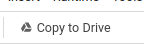


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [26]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1MtaQVJFfhycQ-mnz1LgWqjSnefBhTQ2g', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1RurQxZ_06dXLWLSSzI49M36i7fNmGSyV', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1MtaQVJFfhycQ-mnz1LgWqjSnefBhTQ2g
To: /content/glove.npy
100%|██████████| 480M/480M [00:05<00:00, 90.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1RurQxZ_06dXLWLSSzI49M36i7fNmGSyV
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 189MB/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
!pip install datasets
!pip install transformers

In [28]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [30]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-1deaf0e4869059b7.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b23cfeb68a931a8d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-65e05467bd5c4904.arrow


In [31]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [32]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [33]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [66]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.loss = nn.CrossEntropyLoss()
          self.classifier = nn.Sequential(
              nn.Linear(300, 300),
              nn.ReLU(),
              nn.Linear(300, 100),
              nn.ReLU(),
              nn.Linear(100, 100),
              nn.Sigmoid(),
              nn.Linear(100, 2),       
          )
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedded = self.embeddings(input_ids)
      avg = torch.mean(embedded, 1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [68]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
from collections import OrderedDict

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 25, #must be at least 10.
                                  per_device_train_batch_size= 100,
                                  per_device_eval_batch_size= 80,
                                  learning_rate= 0.01,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")

class CallbackHandler(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
      if 'eval_accuracy' in logs and logs['epoch'] == 20:
        accuracy.append(logs['eval_accuracy'])

accuracy = []


model = DAN()

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                # YOUR CODE HERE
                
                # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.predict(small_eval_dataset)

{'eval_loss': 0.41997554898262024, 'eval_accuracy': 0.81052, 'eval_runtime': 11.6232, 'eval_samples_per_second': 2150.876, 'eval_steps_per_second': 26.929, 'epoch': 1.0}
{'loss': 0.483, 'learning_rate': 0.0092, 'epoch': 2.0}
{'eval_loss': 0.40023350715637207, 'eval_accuracy': 0.8196, 'eval_runtime': 11.6447, 'eval_samples_per_second': 2146.893, 'eval_steps_per_second': 26.879, 'epoch': 2.0}
{'eval_loss': 0.39305227994918823, 'eval_accuracy': 0.82456, 'eval_runtime': 11.4816, 'eval_samples_per_second': 2177.394, 'eval_steps_per_second': 27.261, 'epoch': 3.0}
{'loss': 0.3934, 'learning_rate': 0.0084, 'epoch': 4.0}
{'eval_loss': 0.3830026090145111, 'eval_accuracy': 0.82932, 'eval_runtime': 11.5545, 'eval_samples_per_second': 2163.657, 'eval_steps_per_second': 27.089, 'epoch': 4.0}
{'eval_loss': 0.3834898769855499, 'eval_accuracy': 0.83092, 'eval_runtime': 11.3686, 'eval_samples_per_second': 2199.033, 'eval_steps_per_second': 27.532, 'epoch': 5.0}
{'loss': 0.3867, 'learning_rate': 0.0076, 

PredictionOutput(predictions=array([[-1.2725792 ,  1.3363904 ],
       [ 0.17363483, -0.14836237],
       [ 0.5565399 , -0.5409859 ],
       ...,
       [-0.5157768 ,  0.5609759 ],
       [ 0.18013829, -0.15162395],
       [ 0.32198986, -0.30201182]], dtype=float32), label_ids=array([1, 1, 0, ..., 0, 1, 0]), metrics={'test_loss': 0.3669595420360565, 'test_accuracy': 0.83708, 'test_runtime': 11.5825, 'test_samples_per_second': 2158.422, 'test_steps_per_second': 27.023})

In [86]:
i = 0
for sample in small_eval_dataset:
  result = trainer.predict([sample])
  metrics = result.metrics
  if metrics['test_accuracy'] < 1 and len(sample['text']) < 200:
    print(sample)
    print(result)
    print(str(i) + " " + sample['text'])
    print("\n")
    i+=1
  if i > 9:
    break

{'label': 1, 'text': 'This movie turned out to be better than I had expected it to be. Some parts were pretty funny. It was nice to have a movie with a new plot.'}
PredictionOutput(predictions=array([[ 0.6827612 , -0.65296334]], dtype=float32), label_ids=array([1]), metrics={'test_loss': 1.5691888332366943, 'test_accuracy': 0.0, 'test_runtime': 0.006, 'test_samples_per_second': 166.269, 'test_steps_per_second': 166.269})
0 This movie turned out to be better than I had expected it to be. Some parts were pretty funny. It was nice to have a movie with a new plot.


{'label': 1, 'text': 'Goof: Factual error<br /><br />When Charlie walks out of the room to commit suicide he takes his gun with a silencer. After a few seconds we hear a loud bang from the same gun being fired.'}
PredictionOutput(predictions=array([[ 2.0225997, -2.0956876]], dtype=float32), label_ids=array([1]), metrics={'test_loss': 4.13442850112915, 'test_accuracy': 0.0, 'test_runtime': 0.0061, 'test_samples_per_second': 164.

In [54]:
class DAN2(nn.Module): # for 5c&d
  def __init__(self, layers):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.loss = nn.CrossEntropyLoss()
          self.classifier = nn.Sequential(
              layers           
          )
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedded = self.embeddings(input_ids)
      avg = torch.mean(embedded, 1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [55]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
from collections import OrderedDict

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN2",
                                  # YOUR CODE HERE
                                  num_train_epochs= 20, #must be at least 10.
                                  per_device_train_batch_size= 100,
                                  per_device_eval_batch_size= 80,
                                  learning_rate= 0.01,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")

layers0 = OrderedDict([
              ('dropout', nn.Dropout(0.2)),
              ('linear0', nn.Linear(300,2)),
              ('relu0', nn.ReLU())      
])

layers1 = OrderedDict([
              ('dropout', nn.Dropout(0.2)),
              ('linear0', nn.Linear(300,150)),
              ('relu0', nn.ReLU()),
              ('linear1', nn.Linear(150,2)),
              ('relu1', nn.ReLU())         
])

layers2 = OrderedDict([
              ('dropout', nn.Dropout(0.2)),
              ('linear0', nn.Linear(300,150)),
              ('relu0', nn.ReLU()),
              ('linear1', nn.Linear(150,75)),
              ('relu1', nn.ReLU()),         
              ('linear2', nn.Linear(75,2)),
              ('relu2', nn.ReLU())      
])

layers3 = OrderedDict([
              ('dropout', nn.Dropout(0.2)),
              ('linear0', nn.Linear(300,150)),
              ('relu0', nn.ReLU()),
              ('linear1', nn.Linear(150,75)),
              ('relu1', nn.ReLU()),         
              ('linear2', nn.Linear(75,75)),
              ('relu2', nn.ReLU()),
              ('linear3', nn.Linear(75,2)),         
])

layers = [layers0, layers1, layers2, layers3]


class CallbackHandler(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
      if 'eval_accuracy' in logs and logs['epoch'] == 20:
        accuracy.append(logs['eval_accuracy'])

accuracy = []

for i in range(4):

    model = DAN2(layers[i])
    
    trainer = Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        callbacks = [
                    # YOUR CODE HERE
                      CallbackHandler
                    # END YOUR END
        ],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()




{'eval_loss': 0.6041675209999084, 'eval_accuracy': 0.70992, 'eval_runtime': 11.5828, 'eval_samples_per_second': 2158.363, 'eval_steps_per_second': 27.023, 'epoch': 1.0}
{'loss': 0.6118, 'learning_rate': 0.009000000000000001, 'epoch': 2.0}
{'eval_loss': 0.568803071975708, 'eval_accuracy': 0.74668, 'eval_runtime': 11.8282, 'eval_samples_per_second': 2113.591, 'eval_steps_per_second': 26.462, 'epoch': 2.0}
{'eval_loss': 0.5492926836013794, 'eval_accuracy': 0.76108, 'eval_runtime': 11.609, 'eval_samples_per_second': 2153.496, 'eval_steps_per_second': 26.962, 'epoch': 3.0}
{'loss': 0.5565, 'learning_rate': 0.008, 'epoch': 4.0}
{'eval_loss': 0.5325539112091064, 'eval_accuracy': 0.77668, 'eval_runtime': 11.5805, 'eval_samples_per_second': 2158.798, 'eval_steps_per_second': 27.028, 'epoch': 4.0}
{'eval_loss': 0.5220295786857605, 'eval_accuracy': 0.78292, 'eval_runtime': 11.5974, 'eval_samples_per_second': 2155.658, 'eval_steps_per_second': 26.989, 'epoch': 5.0}
{'loss': 0.5354, 'learning_rate'

In [64]:
co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN2",
                                  # YOUR CODE HERE
                                  num_train_epochs= 20, #must be at least 10.
                                  per_device_train_batch_size= 100,
                                  per_device_eval_batch_size= 80,
                                  learning_rate= 0.01,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")


layers_relu = OrderedDict([
              ('dropout', nn.Dropout(0.2)),
              ('linear0', nn.Linear(300,150)),
              ('relu0', nn.ReLU()),
              ('linear1', nn.Linear(150,2)),
              ('relu1', nn.ReLU())         
])

layers_sigmoid = OrderedDict([
              ('dropout', nn.Dropout(0.2)),
              ('linear0', nn.Linear(300,150)),
              ('sigmoid0', nn.Sigmoid()),
              ('linear1', nn.Linear(150,2)),
              ('sigmoid1', nn.Sigmoid())         
])

layers_softshrink = OrderedDict([
              ('dropout', nn.Dropout(0.2)),
              ('linear0', nn.Linear(300,150)),
              ('Softshrink0', nn.Softshrink(0.2)),
              ('linear1', nn.Linear(150,2)),       
])

accuracy_relu = []
accuracy_sigmoid = []
accuracy_softshrink = []

class CallbackReluHandler(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
      if 'eval_accuracy' in logs:
        accuracy_relu.append(logs['eval_accuracy'])

class CallbacSigmoidHandler(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
      if 'eval_accuracy' in logs:
        accuracy_sigmoid.append(logs['eval_accuracy'])

class CallbackSoftshrinkHandler(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
      if 'eval_accuracy' in logs:
        accuracy_softshrink.append(logs['eval_accuracy'])

model_relu = DAN2(layers_relu)
model_sigmoid = DAN2(layers_sigmoid)
model_softshrink = DAN2(layers_softshrink)
    
trainer_relu = Trainer(
    model=model_relu,
    data_collator=co,
    args=training_args,
    callbacks = [
                # YOUR CODE HERE
                  CallbackReluHandler
                # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer_sigmoid = Trainer(
    model=model_sigmoid,
    data_collator=co,
    args=training_args,
    callbacks = [
                # YOUR CODE HERE
                  CallbacSigmoidHandler
                # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer_softshrink = Trainer(
    model=model_softshrink,
    data_collator=co,
    args=training_args,
    callbacks = [
                # YOUR CODE HERE
                  CallbackSoftshrinkHandler
                # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer_relu.train()
trainer_sigmoid.train()
trainer_softshrink.train()


{'eval_loss': 0.5804297924041748, 'eval_accuracy': 0.7634, 'eval_runtime': 11.5509, 'eval_samples_per_second': 2164.339, 'eval_steps_per_second': 27.098, 'epoch': 1.0}
{'loss': 0.6112, 'learning_rate': 0.009000000000000001, 'epoch': 2.0}
{'eval_loss': 0.5759032964706421, 'eval_accuracy': 0.78844, 'eval_runtime': 11.6511, 'eval_samples_per_second': 2145.729, 'eval_steps_per_second': 26.865, 'epoch': 2.0}
{'eval_loss': 0.5809436440467834, 'eval_accuracy': 0.77516, 'eval_runtime': 11.5015, 'eval_samples_per_second': 2173.639, 'eval_steps_per_second': 27.214, 'epoch': 3.0}
{'loss': 0.5897, 'learning_rate': 0.008, 'epoch': 4.0}
{'eval_loss': 0.5604295134544373, 'eval_accuracy': 0.78424, 'eval_runtime': 11.4871, 'eval_samples_per_second': 2176.356, 'eval_steps_per_second': 27.248, 'epoch': 4.0}
{'eval_loss': 0.5818926095962524, 'eval_accuracy': 0.76748, 'eval_runtime': 11.0474, 'eval_samples_per_second': 2262.981, 'eval_steps_per_second': 28.333, 'epoch': 5.0}
{'loss': 0.5844, 'learning_rate

TrainOutput(global_step=5000, training_loss=0.4845170471191406, metrics={'train_runtime': 479.9765, 'train_samples_per_second': 1041.718, 'train_steps_per_second': 10.417, 'train_loss': 0.4845170471191406, 'epoch': 20.0})

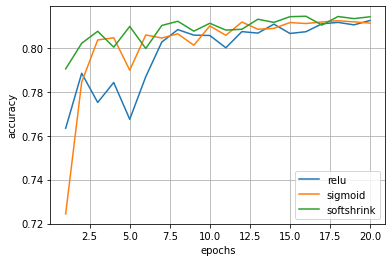

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

# trainer.train()

X = np.arange(1, 21, 1)

plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(X, accuracy_relu, label = 'relu')
plt.plot(X, accuracy_sigmoid, label = 'sigmoid')
plt.plot(X, accuracy_softshrink, label = 'softshrink')
plt.legend()